In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import json
import os
from read_O3_LVK_results import *
import sys
sys.path.append('./../code/')
from utilities import massModel
from scipy.special import erf
from scipy.stats import gaussian_kde
from tqdm import tqdm

In [2]:
precomputed_data = "stored_Xeff_Xp_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    Xeffs = traces['Xeffs']
    Xps = traces['Xps']
    f_Xeffs = traces['f_Xeffs']
    f_Xps = traces['f_Xps']
    R_ref = traces['R_ref']
    bq = traces['bq']
    alpha = traces['alpha']
    mu_m1 = traces['mu_m1']
    sig_m1 = traces['sig_m1']
    log_f_peak = traces['log_f_peak']
    mMin = traces['mMin']
    mMax = traces['mMax']
    log_dmMin = traces['log_dmMin']
    log_dmMax = traces['log_dmMax']
    kappa = traces['kappa']
    
else:

    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_Xeff_Xp.cdf")
    samps = inference_data.posterior.stack(draws=("chain", "draw"))

    # Also extract mass and mass ratio values
    Xeff_Xp_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_Xeff_Xp_data.npy',allow_pickle=True)[()]
    Xeff_values = Xeff_Xp_data['Xeff_allSamples']
    Xp_values = Xeff_Xp_data['Xp_allSamples']

    # For ease of plotting, coarse-grain by a factor of 50
    Xeffs = Xeff_values[::50]
    Xps = Xp_values[::50]

    f_Xeffs = samps['f_Xeffs'].values[::50,:]
    f_Xps = samps['f_Xps'].values[::50,:]

    traces = {
            'Xeffs':Xeffs,
            'Xps':Xps,
            'f_Xeffs':f_Xeffs,
            'f_Xps':f_Xps,
            'R_ref':samps['R20'].values,
            'bq':samps['bq'].values,
            'alpha':samps['alpha'].values,
            'mu_m1':samps['mu_m1'].values,
            'sig_m1':samps['sig_m1'].values,
            'log_f_peak':samps['log_f_peak'].values,
            'mMin':samps['mMin'].values,
            'mMax':samps['mMax'].values,
            'log_dmMin':samps['log_dmMin'].values,
            'log_dmMax':samps['log_dmMax'].values,
            'kappa':samps['kappa'].values
            }

    np.save('stored_Xeff_Xp_data.npy',traces)

In [3]:
lvk_chiEff_grid,lvk_chiP_grid,lvk_R_ref,lvk_p_Xeff_Xp = get_lvk_gaussian_spin()

Removing  GW170817
Removing  S190425z
Removing  S190426c
Removing  S190814bv
Removing  S190917u
Removing  S200105ae
Removing  S200115j
!!!!!! 64.65302232440014


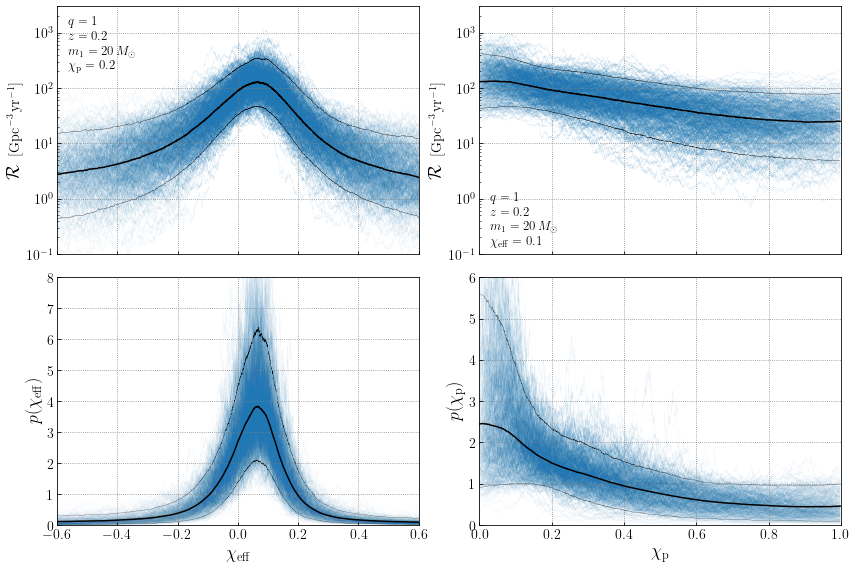

In [4]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)

# Convert to dR/dlnm*dq at m1=20 and q=1
p_q1 = (1.+bq)/(1.-(2./20.)**(1.+bq))
ind_Xp_02 = np.argmin(np.abs(Xps-0.1))
f_Xp_02 = f_Xps[ind_Xp_02,:]
dR_dXeff = R_ref[np.newaxis,:]*f_Xeffs*f_Xp_02*p_q1[np.newaxis,:]*20.
      
for i in np.random.choice(range(dR_dXeff.shape[1]),size=500,replace=False):                 
    ax.plot(Xeffs,dR_dXeff[:,i],color='#1f78b4',alpha=0.2,lw=0.15,zorder=0)
    
ax.plot(Xeffs,np.median(dR_dXeff,axis=1),color='black')
ax.plot(Xeffs,np.quantile(dR_dXeff,0.05,axis=1),color='black',lw=0.3)
ax.plot(Xeffs,np.quantile(dR_dXeff,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.94,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.88,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.82,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.76,r'$\chi_\mathrm{p}=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

ind_Xeff_01 = np.argmin(np.abs(Xeffs-0.05))
f_Xeff_01 = f_Xeffs[ind_Xeff_01,:]
dR_dXp = R_ref[np.newaxis,:]*f_Xps*f_Xeff_01*p_q1[np.newaxis,:]*20.

for i in np.random.choice(range(dR_dXp.shape[1]),size=500,replace=False):                 
    ax.plot(Xps,dR_dXp[:,i],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(Xps,np.median(dR_dXp,axis=1),color='black')
ax.plot(Xps,np.quantile(dR_dXp,0.05,axis=1),color='black',lw=0.3)
ax.plot(Xps,np.quantile(dR_dXp,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

ax.text(0.03,0.23,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.17,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.11,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.05,r'$\chi_\mathrm{eff} = 0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

p_Xeff = f_Xeffs/np.trapz(f_Xeffs,Xeffs,axis=0)

for i in np.random.choice(range(p_Xeff.shape[1]),size=500,replace=False):                 
    ax.plot(Xeffs,p_Xeff[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)
    
ax.plot(Xeffs,np.mean(p_Xeff,axis=1),color='black')
ax.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='black',lw=0.2)
ax.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,8)

ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

p_Xp = f_Xps/np.trapz(f_Xps,Xps,axis=0)

for i in np.random.choice(range(p_Xp.shape[1]),size=500,replace=False):                 
    ax.plot(Xps,p_Xp[:,i],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(Xps,np.mean(p_Xp,axis=1),color='black')
ax.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='black',lw=0.2)
ax.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,6)

ax.set_xlabel('$\chi_\mathrm{p}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{p})$',fontsize=18)

plt.tight_layout()
plt.savefig('Xeff_Xp.pdf',bbox_inches='tight',dpi=200)
plt.show()

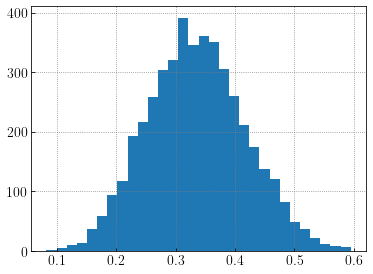

0.3333104339114159 0.14015296650598302 0.13061811971758452


In [18]:
ind_Xeff_00 = np.argmin(np.abs(Xeffs-0.0))

p_neg = np.trapz(p_Xeff[:ind_Xeff_00,:],Xeffs[:ind_Xeff_00],axis=0)

plt.hist(p_neg,bins=30)
plt.show()

print(np.median(p_neg),np.quantile(p_neg,0.95)-np.median(p_neg),np.median(p_neg)-np.quantile(p_neg,0.05))

In [8]:
R_neg = np.zeros(alpha.size)
R_tot = np.zeros(alpha.size)
for i in range(alpha.size):
    
    m1_grid = np.linspace(2,100.,500)
    f_m1 = massModel(m1_grid,
                     alpha[i],mu_m1[i],sig_m1[i],10.**log_f_peak[i],mMax[i],mMin[i],
                     10.**log_dmMax[i],10.**log_dmMin[i])
    f_m1_norm = massModel(20.,
                     alpha[i],mu_m1[i],sig_m1[i],10.**log_f_peak[i],mMax[i],mMin[i],
                     10.**log_dmMax[i],10.**log_dmMin[i])
    
    int_m1 = np.trapz(f_m1/f_m1_norm,m1_grid)
    int_Xeff = np.trapz(f_Xeffs[:,i],Xeffs)
    int_Xp = np.trapz(f_Xps[:,i],Xps)
    
    negative_Xeff = Xeffs<0
    int_neg = np.trapz(f_Xeffs[negative_Xeff,i],Xeffs[negative_Xeff])
        
    R_neg[i] = R_ref[i]*int_m1*int_Xp*int_neg
    R_tot[i] = R_ref[i]*int_m1*int_Xp*int_Xeff
    
print(np.median(R_neg),
      np.quantile(R_neg,0.95)-np.quantile(R_neg,0.5),
      np.quantile(R_neg,0.5)-np.quantile(R_neg,0.05))

9.350860841501579 7.602448631219893 4.452084970786366


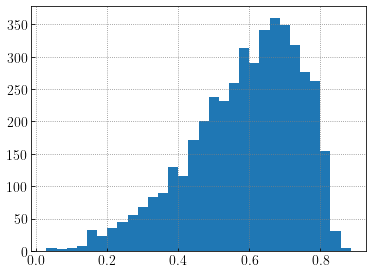

0.612903657895256 0.18283481187747608 0.3200811077959423


In [33]:
ind_Xp_02 = np.argmin(np.abs(Xps-0.2))

p_large = np.trapz(p_Xp[ind_Xp_02:,:],Xps[ind_Xp_02:],axis=0)

plt.hist(p_large,bins=30)
plt.show()

print(np.median(p_large),np.quantile(p_large,0.95)-np.median(p_large),np.median(p_large)-np.quantile(p_large,0.05))

0.9757777777777777


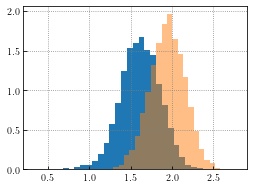

In [12]:
ind_Xeff_n01 = np.argmin(np.abs(Xeffs+0.1))
ind_Xeff_00 = np.argmin(np.abs(Xeffs-0.0))
ind_Xeff_01 = np.argmin(np.abs(Xeffs-0.1))

R_Xeff_n01_to_Xeff_00 = np.trapz(dR_dXeff[ind_Xeff_n01:ind_Xeff_00,:],Xeffs[ind_Xeff_n01:ind_Xeff_00],axis=0)/0.1
R_Xeff_00_to_Xeff_01 = np.trapz(dR_dXeff[ind_Xeff_00:ind_Xeff_01,:],Xeffs[ind_Xeff_00:ind_Xeff_01],axis=0)/0.1

print(R_Xeff_00_to_Xeff_01[R_Xeff_00_to_Xeff_01>R_Xeff_n01_to_Xeff_00].size/R_Xeff_00_to_Xeff_01.size)

fig,ax = plt.subplots()
ax.hist(np.log10(R_Xeff_n01_to_Xeff_00),density=True,bins=30)
ax.hist(np.log10(R_Xeff_00_to_Xeff_01),density=True,bins=30,alpha=0.5)
plt.show()

In [62]:
print(np.median(mean_Xeff),
      np.quantile(mean_Xeff,0.95)-np.median(mean_Xeff),
      np.median(mean_Xeff)-np.quantile(mean_Xeff,0.05))

0.02603188495628929 0.050791147606034426 0.07592969562527194


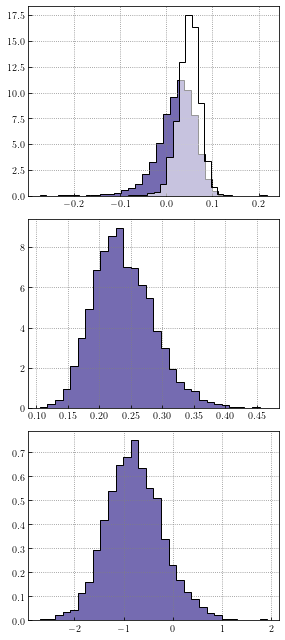

In [59]:
median_Xeff = np.zeros(dR_dXeff.shape[1])
for i in range(dR_dXeff.shape[1]):
    cdf_Xeff = np.cumsum(dR_dXeff[:-1,i]*np.diff(Xeffs))
    cdf_Xeff /= cdf_Xeff[-1]
    median_Xeff[i] = np.interp(0.5,cdf_Xeff,Xeffs[:-1])

mean_Xeff = np.trapz(Xeffs[:,np.newaxis]*dR_dXeff[:,:],Xeffs,axis=0)/np.trapz(dR_dXeff,Xeffs,axis=0)
var_Xeff = np.trapz((Xeffs[:,np.newaxis]-mean_Xeff[np.newaxis,:])**2*dR_dXeff[:,:],Xeffs,axis=0)/np.trapz(dR_dXeff,Xeffs,axis=0)
std_Xeff = np.sqrt(var_Xeff)
skew_Xeff = np.trapz(((Xeffs[:,np.newaxis]-mean_Xeff[np.newaxis,:])/std_Xeff[np.newaxis,:])**3*dR_dXeff[:,:],Xeffs,axis=0)/\
    np.trapz(dR_dXeff,Xeffs,axis=0)

fig = plt.figure(figsize=(4,9))

ax = fig.add_subplot(311)
ax.set_rasterization_zorder(1)
ax.hist(mean_Xeff,density=True,bins=30,color='#756bb1',histtype='stepfilled',zorder=1)
ax.hist(mean_Xeff,density=True,bins=30,color='black',histtype='step',zorder=1)
ax.hist(median_Xeff,density=True,bins=30,color='white',histtype='stepfilled',alpha=0.6,zorder=2)
ax.hist(median_Xeff,density=True,bins=30,color='black',histtype='step',zorder=2)
#ax.hist(median_Xeff,density=True,bins=30,color='#756bb1')
#ax.set_xlim(3,400)
#ax.set_ylim(3,400)

ax = fig.add_subplot(312)
ax.set_rasterization_zorder(1)
ax.hist(std_Xeff,density=True,bins=30,color='#756bb1',histtype='stepfilled')
ax.hist(std_Xeff,density=True,bins=30,color='black',histtype='step')

ax = fig.add_subplot(313)
ax.set_rasterization_zorder(1)
ax.hist(skew_Xeff,density=True,bins=30,color='#756bb1',histtype='stepfilled')
ax.hist(skew_Xeff,density=True,bins=30,color='black',histtype='step')


plt.tight_layout()
#plt.savefig('rate_growth.pdf',bbox_inches='tight',dpi=200)
plt.show()

2.930100959962807 1.997997997997998
-0.3974535207508635


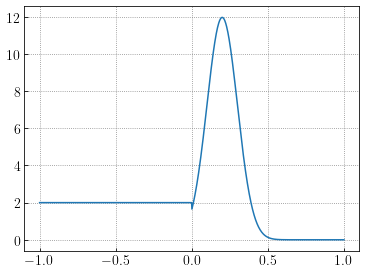

In [53]:
xs = np.linspace(-1,1,1000)
ys = np.zeros(xs.size)
ys[xs<0] = 2
ys[xs>0] = 3.*np.exp(-(xs[xs>0]-0.2)**2/(2.*0.1**2))/np.sqrt(2.*np.pi*0.1**2)

fig,ax = plt.subplots()
ax.plot(xs,ys)

print(np.trapz(ys[xs>0],xs[xs>0]),np.trapz(ys[xs<0],xs[xs<0]))
print(np.trapz(xs*ys,xs))

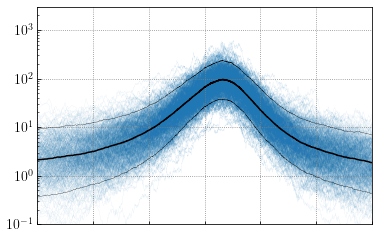

In [29]:
fig = plt.figure(figsize=(6,4))

#########################
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

# Convert to dR/dlnm*dq at m1=20 and q=1
p_q1 = (1.+bq)/(1.-(2./20.)**(1.+bq))
ind_Xp_02 = np.argmin(np.abs(Xps-0.2))
f_Xp_02 = f_Xps[ind_Xp_02,:]
dR_dXeff = R_ref[np.newaxis,:]*f_Xeffs*f_Xp_02*p_q1[np.newaxis,:]*20.
      
for i in np.random.choice(range(dR_dXeff.shape[1]),size=500,replace=False):                 
    ax.plot(Xeffs,dR_dXeff[:,i],color='#1f78b4',alpha=0.2,lw=0.15,zorder=0)
    
ax.plot(Xeffs,np.median(dR_dXeff,axis=1),color='black')
ax.plot(Xeffs,np.quantile(dR_dXeff,0.05,axis=1),color='black',lw=0.3)
ax.plot(Xeffs,np.quantile(dR_dXeff,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])

plt.show()

In [4]:
component_data = "stored_chi_cost_data.npy"
traces = np.load(component_data,allow_pickle=True)[()]
component_chis = traces['chis']
component_costs = traces['costs']
component_f_chis = traces['f_chis']
component_f_costs = traces['f_costs']
component_R_ref = traces['R_ref']
component_bq = traces['bq']
component_alpha = traces['alpha']
component_mu_m1 = traces['mu_m1']
component_sig_m1 = traces['sig_m1']
component_log_f_peak = traces['log_f_peak']
component_mMin = traces['mMin']
component_mMax = traces['mMax']
component_log_dmMin = traces['log_dmMin']
component_log_dmMax = traces['log_dmMax']

R0_tot = np.zeros(component_R_ref.size)
for i in tqdm(range(component_R_ref.size)):

    m1_grid = np.linspace(2.,100.,500)
    f_m1 = massModel(m1_grid,
                     component_alpha[i],
                     component_mu_m1[i],
                     component_sig_m1[i],
                     10.**component_log_f_peak[i],
                     component_mMax[i],
                     component_mMin[i],
                     10.**component_log_dmMax[i],
                     10.**component_log_dmMin[i]
                    )
    f_m1_20 = massModel(20.,
                     component_alpha[i],
                     component_mu_m1[i],
                     component_sig_m1[i],
                     10.**component_log_f_peak[i],
                     component_mMax[i],
                     component_mMin[i],
                     10.**component_log_dmMax[i],
                     10.**component_log_dmMin[i]
                    )
    f_q_1 = (1.+component_bq[i])/(1. - (2./20.)**(1.+component_bq[i]))
    f_chi_integral = np.trapz(component_f_chis[i,:],component_chis)
    f_cost_integral = np.trapz(component_f_costs[i,:],component_costs)
    
    R0_tot[i] = component_R_ref[i]*(f_chi_integral*f_cost_integral)**2*f_q_1

p_chis = component_f_chis/np.trapz(component_f_chis,component_chis,axis=1)[:,np.newaxis]
p_costs = component_f_costs/np.trapz(component_f_costs,component_costs,axis=1)[:,np.newaxis]

chi_cdf = np.cumsum(p_chis[:,1:]*np.diff(component_chis)[np.newaxis,:],axis=1)
chi_cdf /= chi_cdf[:,-1][:,np.newaxis]

cost_cdf = np.cumsum(p_costs[:,1:]*np.diff(component_costs)[np.newaxis,:],axis=1)
cost_cdf /= cost_cdf[:,-1][:,np.newaxis]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:00<00:00, 4925.17it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 43.16it/s]


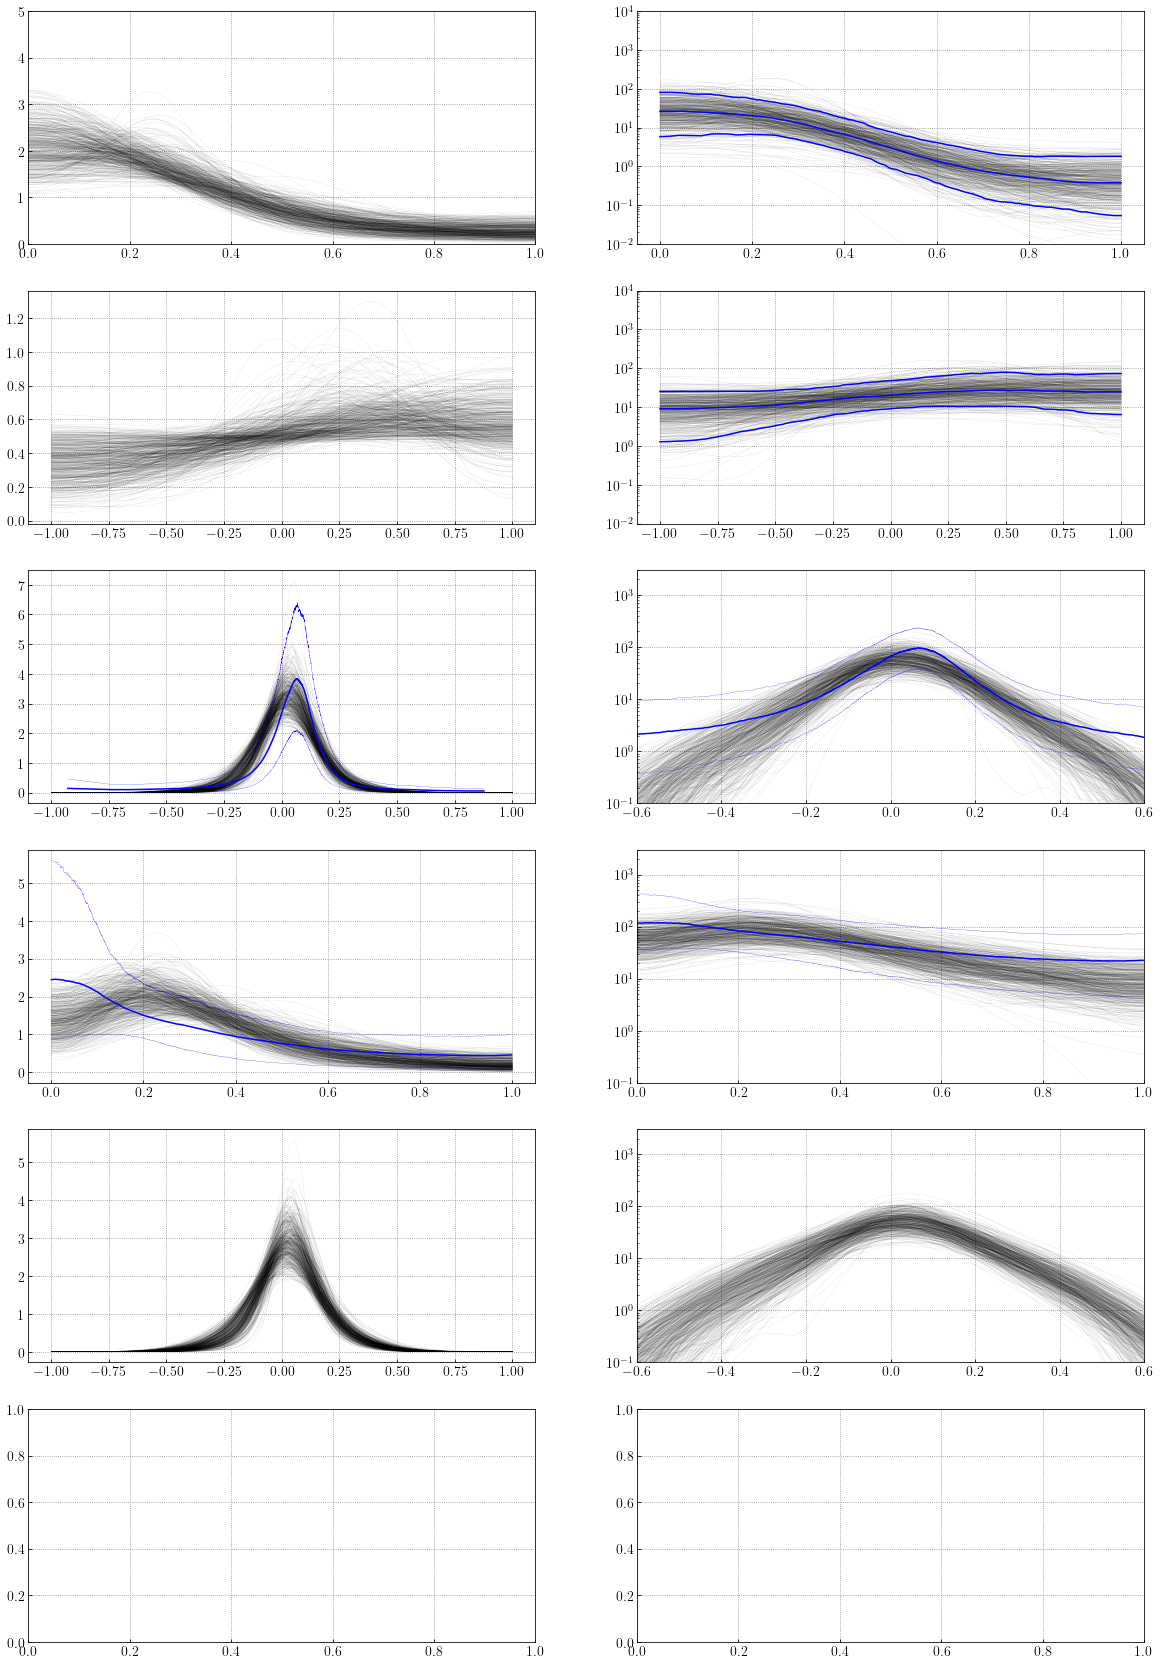

In [38]:
fig = plt.figure(figsize=(20,30))

ax11 = fig.add_subplot(621)
ax12 = fig.add_subplot(622)
ax21 = fig.add_subplot(623)
ax22 = fig.add_subplot(624)
ax31 = fig.add_subplot(625)
ax32 = fig.add_subplot(626)
ax41 = fig.add_subplot(627)
ax42 = fig.add_subplot(628)
ax51 = fig.add_subplot(629)
ax52 = fig.add_subplot(6,2,10)
ax61 = fig.add_subplot(6,2,11)
ax62 = fig.add_subplot(6,2,12)

R_a = np.zeros((500,200))
R_cost = np.zeros((500,200))
p_Xeffs_1 = np.zeros((500,200))
p_Xeffs_2 = np.zeros((500,200))

for i in tqdm(range(500)):
    
    cdf_draws = np.random.random(1000)
    a1_draws = np.interp(cdf_draws,chi_cdf[i,:],component_chis[1:])
    
    cdf_draws = np.random.random(1000)
    a2_draws = np.interp(cdf_draws,chi_cdf[i,:],component_chis[1:])
    
    cdf_draws = np.random.random(1000)
    cost1_draws = np.interp(cdf_draws,cost_cdf[i,:],component_costs[1:])
    
    cdf_draws = np.random.random(1000)
    cost2_draws = np.interp(cdf_draws,cost_cdf[i,:],component_costs[1:])
    
    a_grid = np.linspace(0,1,200)
    cost_grid = np.linspace(-1,1,200)
    Xeff_grid = np.linspace(-1,1,200)
    Xp_grid = np.linspace(0,1,200)
    
    
    ########################################################
    # Spin magnitude
    ########################################################

    a_kde = gaussian_kde(np.concatenate([a1_draws,a2_draws]),bw_method=0.5)
    cost_kde = gaussian_kde(np.concatenate([cost1_draws,cost2_draws]),bw_method=0.5)
    p_a = a_kde(a_grid)+a_kde(-a_grid)+a_kde(2-a_grid)
    p_cost = cost_kde(cost_grid)+cost_kde(-2-cost_grid)+cost_kde(2-cost_grid)
    
    ax11.plot(a_grid,p_a,color='black',lw=0.2,alpha=0.2)
    ax11.set_xlim(0,1)
    ax11.set_ylim(0,5)
    
    p_cost_1 = p_cost[-1]
    R_a[i,:] = R0_tot[i]*20.*p_a**2*p_cost_1**2
    
    ax12.plot(a_grid,R_a[i,:],color='black',lw=0.2,alpha=0.2)
    ax12.set_yscale('log')
    ax12.set_ylim(1e-2,1e4)
    
    ########################################################
    # Spin tilt
    ########################################################
                         
    ax21.plot(cost_grid,p_cost,color='black',lw=0.2,alpha=0.2)
    
    p_a_01 = a_kde(0.1)+a_kde(-0.1)+a_kde(2-0.1)
    R_cost[i,:] = R0_tot[i]*20.*p_cost**2*p_a_01**2
    
    ax22.plot(cost_grid,R_cost[i,:],color='black',lw=0.2,alpha=0.2)
    ax22.set_yscale('log')
    ax22.set_ylim(1e-2,1e4)
    
    ########################################################
    # Xeff
    ########################################################
    
    q_draws = 1.
    sint1_draws = np.sqrt(1.-cost1_draws**2)
    sint2_draws = np.sqrt(1.-cost2_draws**2)
    Xeff_draws = (a1_draws*cost1_draws + a2_draws*cost2_draws)/2.
    Xp_draws = np.maximum(a1_draws*sint1_draws,(3.+4.*q_draws)/(4.+3.*q_draws)*q_draws*a2_draws*sint2_draws)
    
    Xeff_Xp_kde = gaussian_kde(np.array([Xeff_draws,Xp_draws]),bw_method=0.5)
    Xeff_kde = gaussian_kde(Xeff_draws,bw_method=0.5)
    Xp_kde = gaussian_kde(Xp_draws,bw_method=0.05)
    
    p_Xeff_trial1 = Xeff_Xp_kde([Xeff_grid,0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([-2-Xeff_grid,0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([2-Xeff_grid,0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([Xeff_grid,-0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([-2-Xeff_grid,-0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([2-Xeff_grid,-0.2*np.ones(Xeff_grid.size)])\
    
    p_Xeff_trial1 = p_Xeff_trial1/np.trapz(p_Xeff_trial1,Xeff_grid)
    p_Xeffs_1[i,:] = p_Xeff_trial1
    
    ax31.plot(Xeff_grid,p_Xeff_trial1,color='black',lw=0.2,alpha=0.2)
    ax32.plot(Xeff_grid,R0_tot[i]*20.*p_Xeff_trial1,color='black',lw=0.2,alpha=0.2)
    ax32.set_xlim(-0.6,0.6)
    ax32.set_ylim(1e-1,3e3)
    ax32.set_yscale('log')
    
    p_Xp_trial1 = Xeff_Xp_kde([0.1*np.ones(Xp_grid.size),Xp_grid])\
            + Xeff_Xp_kde([0.1*np.ones(Xp_grid.size),-Xp_grid])\
            + Xeff_Xp_kde([0.1*np.ones(Xp_grid.size),2-Xp_grid])
    
    ax41.plot(Xp_grid,p_Xp_trial1/np.trapz(p_Xp_trial1,Xp_grid),color='black',lw=0.2,alpha=0.2)
    ax42.plot(Xp_grid,R0_tot[i]*20.*p_Xp_trial1,color='black',lw=0.2,alpha=0.2)
    ax42.set_xlim(0,1)
    ax42.set_ylim(1e-1,3e3)
    ax42.set_yscale('log')
    
    p_Xeff_trial2 = Xeff_kde(Xeff_grid)+Xeff_kde(-2-Xeff_grid)+Xeff_kde(2-Xeff_grid)
    p_Xeffs_2[i,:] = p_Xeff_trial2
    
    ax51.plot(Xeff_grid,p_Xeff_trial2,color='black',lw=0.2,alpha=0.2)
    ax52.plot(Xeff_grid,R0_tot[i]*20.*p_Xeff_trial2,color='black',lw=0.2,alpha=0.2)
    ax52.set_xlim(-0.6,0.6)
    ax52.set_ylim(1e-1,3e3)
    ax52.set_yscale('log')
    
ax12.plot(a_grid,np.median(R_a,axis=0),color='blue')
ax12.plot(a_grid,np.quantile(R_a,0.05,axis=0),color='blue')
ax12.plot(a_grid,np.quantile(R_a,0.95,axis=0),color='blue')

ax22.plot(cost_grid,np.median(R_cost,axis=0),color='blue')
ax22.plot(cost_grid,np.quantile(R_cost,0.05,axis=0),color='blue')
ax22.plot(cost_grid,np.quantile(R_cost,0.95,axis=0),color='blue')
    
ax31.plot(Xeffs,np.mean(p_Xeff,axis=1),color='blue')
ax31.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='blue',lw=0.2)
ax31.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='blue',lw=0.2)

ax32.plot(Xeffs,np.median(dR_dXeff,axis=1),color='blue')
ax32.plot(Xeffs,np.quantile(dR_dXeff,0.05,axis=1),color='blue',lw=0.2)
ax32.plot(Xeffs,np.quantile(dR_dXeff,0.95,axis=1),color='blue',lw=0.2)

ax41.plot(Xps,np.mean(p_Xp,axis=1),color='blue')
ax41.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='blue',lw=0.2)
ax41.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='blue',lw=0.2)

ax42.plot(Xps,np.median(dR_dXp,axis=1),color='blue')
ax42.plot(Xps,np.quantile(dR_dXp,0.05,axis=1),color='blue',lw=0.2)
ax42.plot(Xps,np.quantile(dR_dXp,0.95,axis=1),color='blue',lw=0.2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 118.21it/s]


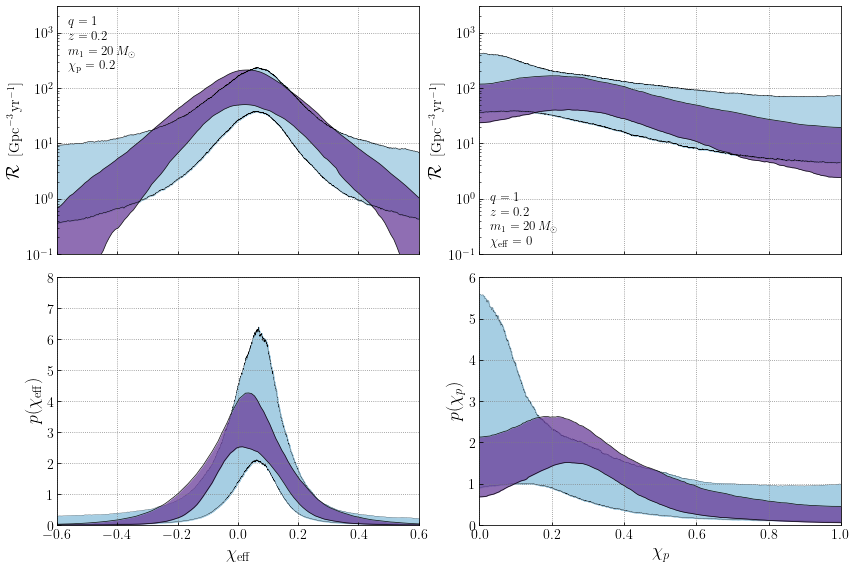

In [6]:
R_Xeffs_from_component = np.zeros((500,200))
p_Xeffs_from_component = np.zeros((500,200))
R_Xps_from_component = np.zeros((500,200))
p_Xps_from_component = np.zeros((500,200))

for i in tqdm(range(500)):
    
    cdf_draws = np.random.random(1000)
    a1_draws = np.interp(cdf_draws,chi_cdf[i,:],component_chis[1:])
    
    cdf_draws = np.random.random(1000)
    a2_draws = np.interp(cdf_draws,chi_cdf[i,:],component_chis[1:])
    
    cdf_draws = np.random.random(1000)
    cost1_draws = np.interp(cdf_draws,cost_cdf[i,:],component_costs[1:])
    
    cdf_draws = np.random.random(1000)
    cost2_draws = np.interp(cdf_draws,cost_cdf[i,:],component_costs[1:])
    
    a_grid = np.linspace(0,1,200)
    cost_grid = np.linspace(-1,1,200)
    Xeff_grid = np.linspace(-1,1,200)
    Xp_grid = np.linspace(0,1,200)
    
    ########################################################
    # Xeff
    ########################################################
    
    q_draws = 1.
    sint1_draws = np.sqrt(1.-cost1_draws**2)
    sint2_draws = np.sqrt(1.-cost2_draws**2)
    Xeff_draws = (a1_draws*cost1_draws + a2_draws*cost2_draws)/2.
    Xp_draws = np.maximum(a1_draws*sint1_draws,(3.+4.*q_draws)/(4.+3.*q_draws)*q_draws*a2_draws*sint2_draws)
    
    Xeff_Xp_kde = gaussian_kde(np.array([Xeff_draws,Xp_draws]),bw_method=0.5)
    Xeff_kde = gaussian_kde(Xeff_draws,bw_method=0.5)
    Xp_kde = gaussian_kde(Xp_draws,bw_method=0.5)
    
    p_Xeff_kde = Xeff_Xp_kde([Xeff_grid,0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([-2-Xeff_grid,0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([2-Xeff_grid,0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([Xeff_grid,-0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([-2-Xeff_grid,-0.2*np.ones(Xeff_grid.size)])\
            + Xeff_Xp_kde([2-Xeff_grid,-0.2*np.ones(Xeff_grid.size)])\
    
    R_Xeffs_from_component[i,:] = R0_tot[i]*20.*p_Xeff_kde
    p_Xeff_marg = p_Xeff_kde/np.trapz(p_Xeff_kde,Xeff_grid)
    p_Xeffs_from_component[i,:] = p_Xeff_marg
    
    
    p_Xp_kde = Xeff_Xp_kde([0.1*np.ones(Xp_grid.size),Xp_grid])\
            + Xeff_Xp_kde([0.1*np.ones(Xp_grid.size),-Xp_grid])\
            + Xeff_Xp_kde([0.1*np.ones(Xp_grid.size),2-Xp_grid])
    
    R_Xps_from_component[i,:] = R0_tot[i]*20.*p_Xp_kde
    p_Xp_marg = p_Xp_kde/np.trapz(p_Xp_kde,Xp_grid)
    p_Xps_from_component[i,:] = p_Xp_marg
    
fig = plt.figure(figsize=(12,8))

###############################################################
# Plot R(Xeff)
###############################################################

ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)
    
ax.plot(Xeffs,np.quantile(dR_dXeff,0.05,axis=1),color='black',lw=0.5)
ax.plot(Xeffs,np.quantile(dR_dXeff,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(Xeffs,
                np.quantile(dR_dXeff,0.05,axis=1),
                np.quantile(dR_dXeff,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1)

ax.plot(Xeff_grid,np.quantile(R_Xeffs_from_component,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(Xeff_grid,np.quantile(R_Xeffs_from_component,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(Xeff_grid,
                np.quantile(R_Xeffs_from_component,0.05,axis=0),
                np.quantile(R_Xeffs_from_component,0.95,axis=0),
                color='#6a3d9a',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.94,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.88,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.82,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.76,r'$\chi_\mathrm{p}=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

###############################################################
# Plot R(Xp)
###############################################################

ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

ax.plot(Xps,np.quantile(dR_dXp,0.05,axis=1),color='black',lw=0.5)
ax.plot(Xps,np.quantile(dR_dXp,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(Xps,
                np.quantile(dR_dXp,0.05,axis=1),
                np.quantile(dR_dXp,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1)

ax.plot(Xp_grid,np.quantile(R_Xps_from_component,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(Xp_grid,np.quantile(R_Xps_from_component,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(Xp_grid,
                np.quantile(R_Xps_from_component,0.05,axis=0),
                np.quantile(R_Xps_from_component,0.95,axis=0),
                color='#6a3d9a',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-1,3e3)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

ax.text(0.03,0.23,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.17,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.11,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.05,r'$\chi_\mathrm{eff} = 0$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

###############################################################
# Plot p(Xeff)
###############################################################

ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

ax.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='black',lw=0.3,zorder=0)
ax.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='black',lw=0.2,zorder=0)
ax.fill_between(Xeffs,
                np.quantile(p_Xeff,0.05,axis=1),
                np.quantile(p_Xeff,0.95,axis=1),
                color='#a6cee3',alpha=1,zorder=-1)

ax.plot(Xeff_grid,np.quantile(p_Xeffs_from_component,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(Xeff_grid,np.quantile(p_Xeffs_from_component,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(Xeff_grid,
                np.quantile(p_Xeffs_from_component,0.05,axis=0),
                np.quantile(p_Xeffs_from_component,0.95,axis=0),
                color='#6a3d9a',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,8)

ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

###############################################################
# Plot p(Xp)
###############################################################

ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

ax.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='black',lw=0.3,zorder=0)
ax.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='black',lw=0.2,zorder=0)
ax.fill_between(Xps,
                np.quantile(p_Xp,0.05,axis=1),
                np.quantile(p_Xp,0.95,axis=1),
                color='#a6cee3',alpha=1,zorder=-1)

ax.plot(Xp_grid,np.quantile(p_Xps_from_component,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(Xp_grid,np.quantile(p_Xps_from_component,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(Xp_grid,
                np.quantile(p_Xps_from_component,0.05,axis=0),
                np.quantile(p_Xps_from_component,0.95,axis=0),
                color='#6a3d9a',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,6)

ax.set_xlabel('$\chi_p$',fontsize=18)
ax.set_ylabel(r'$p(\chi_p)$',fontsize=18)

plt.tight_layout()
plt.savefig('spin_model_comparison.pdf',bbox_inches='tight',dpi=200)

In [6]:
test = np.median(np.log10(lvk_R_Xeff_Xp),axis=0).T

In [7]:
dR_dXeff_dXp = R_ref[::10,np.newaxis,np.newaxis]*f_Xeffs.T[::10,np.newaxis,::10]*f_Xps.T[::10,::10,np.newaxis]*p_q1[::10,np.newaxis,np.newaxis]*20.

In [8]:
test2 = np.median(np.log10(dR_dXeff_dXp),axis=0)

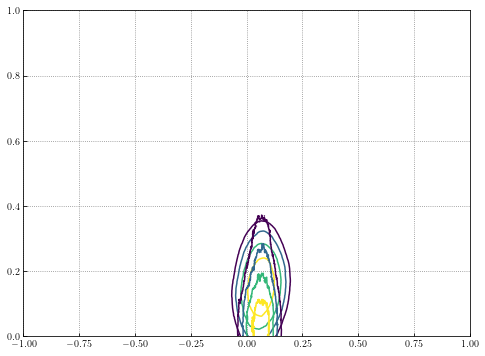

In [9]:
fig,ax = plt.subplots(figsize=(8,6))

#ax.pcolormesh(lvk_chiEff_grid,lvk_chiP_grid,np.median(np.log10(lvk_R_Xeff_Xp),axis=0).T,cmap='Blues')
ax.contour(lvk_chiEff_grid,lvk_chiP_grid,test,levels=np.arange(1.8,2.1,0.1))
ax.contour(Xeffs[::10],Xps[::10],test2,levels=np.arange(1.8,2.1,0.1))

In [5]:
lvk_R_Xeff_Xp = lvk_R_ref[:,np.newaxis,np.newaxis]*lvk_p_Xeff_Xp

ind_Xeff_01 = np.argmin(np.abs(lvk_chiEff_grid-0.05))
ind_Xp_02 = np.argmin(np.abs(lvk_chiP_grid-0.1))

lvk_R_Xeff = lvk_R_Xeff_Xp[:,:,ind_Xp_02]
lvk_R_Xp = lvk_R_Xeff_Xp[:,ind_Xeff_01,:]

lvk_p_Xeff = lvk_R_Xeff/np.trapz(lvk_R_Xeff,lvk_chiEff_grid,axis=1)[:,np.newaxis]
lvk_p_Xp = lvk_R_Xp/np.trapz(lvk_R_Xp,lvk_chiP_grid,axis=1)[:,np.newaxis]

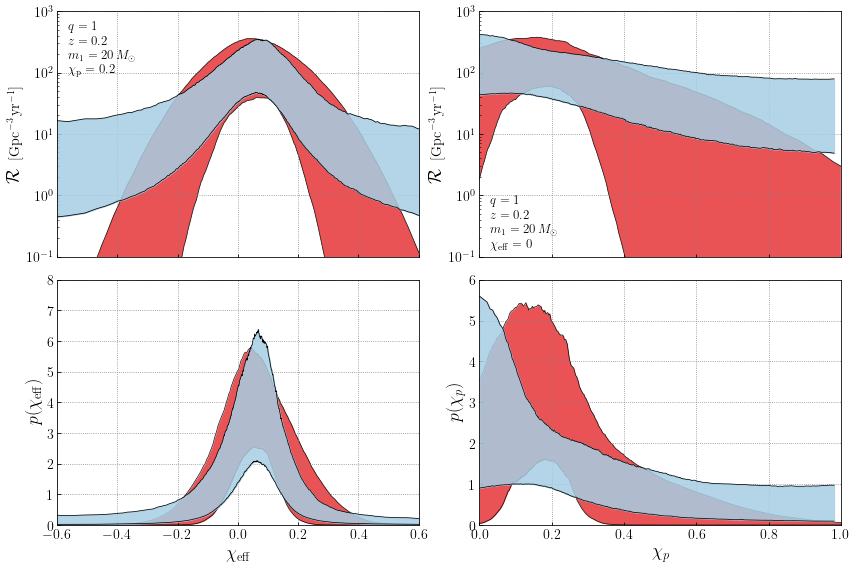

In [25]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(4)
    
ax.plot(Xeffs[::10],np.quantile(dR_dXeff[::10],0.05,axis=1),color='black',lw=0.775,zorder=3)
ax.plot(Xeffs[::10],np.quantile(dR_dXeff[::10],0.95,axis=1),color='black',lw=0.775,zorder=3)
ax.fill_between(Xeffs[::10],
                np.quantile(dR_dXeff[::10],0.05,axis=1),
                np.quantile(dR_dXeff[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

ax.plot(lvk_chiEff_grid,np.quantile(lvk_R_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_chiEff_grid,np.quantile(lvk_R_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_chiEff_grid,
                np.quantile(lvk_R_Xeff,0.05,axis=0),
                np.quantile(lvk_R_Xeff,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,1e3)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.94,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.88,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.82,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.76,r'$\chi_\mathrm{p}=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(4)

ax.plot(Xps[::10],np.quantile(dR_dXp[::10],0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xps[::10],np.quantile(dR_dXp[::10],0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xps[::10],
                np.quantile(dR_dXp[::10],0.05,axis=1),
                np.quantile(dR_dXp[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

ax.plot(lvk_chiP_grid,np.quantile(lvk_R_Xp,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_chiP_grid,np.quantile(lvk_R_Xp,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_chiP_grid,
                np.quantile(lvk_R_Xp,0.05,axis=0),
                np.quantile(lvk_R_Xp,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-1,1e3)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

ax.text(0.03,0.23,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.17,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.11,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.05,r'$\chi_\mathrm{eff} = 0$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(4)

ax.plot(Xeffs[::10],np.quantile(p_Xeff[::10],0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xeffs[::10],np.quantile(p_Xeff[::10],0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xeffs[::10],
                np.quantile(p_Xeff[::10],0.05,axis=1),
                np.quantile(p_Xeff[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

ax.plot(lvk_chiEff_grid,np.quantile(lvk_p_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_chiEff_grid,np.quantile(lvk_p_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_chiEff_grid,
                np.quantile(lvk_p_Xeff,0.05,axis=0),
                np.quantile(lvk_p_Xeff,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,8)

ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(4)

ax.plot(Xps[::10],np.quantile(p_Xp[::10],0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xps[::10],np.quantile(p_Xp[::10],0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xps[::10],
                np.quantile(p_Xp[::10],0.05,axis=1),
                np.quantile(p_Xp[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

ax.plot(lvk_chiP_grid,np.quantile(lvk_p_Xp,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_chiP_grid,np.quantile(lvk_p_Xp,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_chiP_grid,
                np.quantile(lvk_p_Xp,0.05,axis=0),
                np.quantile(lvk_p_Xp,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,6)

ax.set_xlabel('$\chi_p$',fontsize=18)
ax.set_ylabel(r'$p(\chi_p)$',fontsize=18)

plt.tight_layout()
plt.savefig('Xeff_Xp_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [80]:
def truncatedNormal(x,mu,sig,xmin):
    
    norm = 0.5*(erf((1.-mu)/np.sqrt(2.*sig**2)) - erf((xmin-mu)/np.sqrt(2.*sig**2)))
    return np.exp(-(x-mu)**2/(2.*sig**2))/np.sqrt(2.*np.pi*sig**2)/norm

def lorentzian(x,mu,gamma,xmin):
    
    norm = (np.arctan((1.-mu)/gamma) - np.arctan((xmin-mu)/gamma))/np.pi
    return (1./(np.pi*gamma))*1./(1.+((x-mu)/gamma)**2)/norm

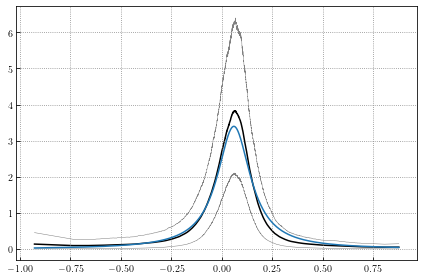

In [84]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

ax.plot(Xeffs,np.mean(p_Xeff,axis=1),color='black',zorder=1)
ax.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='grey',lw=0.5,zorder=1)

xeff_mu = 0.06
xeff_sigma = 0.12
#ax.plot(Xeffs,truncatedNormal(Xeffs,xeff_mu,xeff_sigma))

xeff_mu_lorentzian = 0.06
xeff_gamma = 0.1
ax.plot(Xeffs,lorentzian(Xeffs,xeff_mu_lorentzian,xeff_gamma,-1))

plt.tight_layout()
plt.show()

In [85]:
from scipy.optimize import minimize

p_Xeff_target = np.mean(p_Xeff,axis=1)

def ls_gaussian(params):
    
    mu,sig = params
    p_Xeff_model = truncatedNormal(Xeffs,mu,sig,-1)
    
    return np.trapz((p_Xeff_model-p_Xeff_target)**2,Xeffs)

def ls_lorentzian(params):
    
    mu,gamma = params
    p_Xeff_model = lorentzian(Xeffs,mu,gamma,-1)
    
    return np.trapz((p_Xeff_model-p_Xeff_target)**2,Xeffs)

initial_params_gaussian = (xeff_mu,xeff_sigma)
xeff_gaussian_soln = minimize(ls_gaussian,
                         initial_params_gaussian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

initial_params_lorentzian = (xeff_mu_lorentzian,xeff_gamma)
xeff_lorentzian_soln = minimize(ls_lorentzian,
                         initial_params_lorentzian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

print(xeff_gaussian_soln.success,xeff_gaussian_soln.x)
print(xeff_lorentzian_soln.success,xeff_lorentzian_soln.x)

True [0.05696358 0.110403  ]
True [0.05989861 0.08644121]


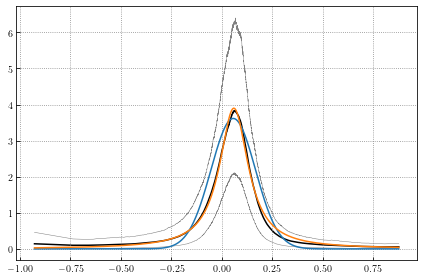

In [104]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

ax.plot(Xeffs,np.mean(p_Xeff,axis=1),color='black',zorder=1)
ax.plot(Xeffs,np.quantile(p_Xeff,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(Xeffs,np.quantile(p_Xeff,0.95,axis=1),color='grey',lw=0.5,zorder=1)

ax.plot(Xeffs,truncatedNormal(Xeffs,*gaussian_soln.x,-1))
ax.plot(Xeffs,lorentzian(Xeffs,*xeff_lorentzian_soln.x,-1))

plt.tight_layout()
plt.show()

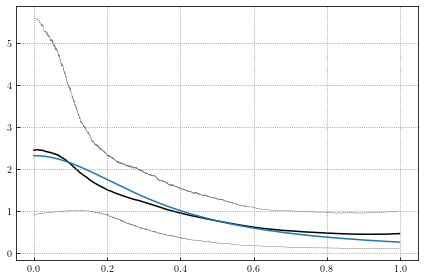

In [87]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

ax.plot(Xps,np.mean(p_Xp,axis=1),color='black',zorder=1)
ax.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='grey',lw=0.5,zorder=1)

xp_mu = 0.0
xp_sigma = 0.5
#ax.plot(Xps,truncatedNormal(Xps,xp_mu,xp_sigma,0))

xp_mu_lorentzian = 0.0
xp_gamma = 0.35
ax.plot(Xps,lorentzian(Xps,xp_mu_lorentzian,xp_gamma,0))

plt.tight_layout()
plt.show()

In [90]:
p_Xp_target = np.mean(p_Xp,axis=1)

def ls_gaussian(params):
    
    mu,sig = params
    p_Xp_model = truncatedNormal(Xps,mu,sig,0)
    
    return np.trapz((p_Xp_model-p_Xp_target)**2,Xps)

def ls_lorentzian(params):
    
    mu,gamma = params
    p_Xp_model = lorentzian(Xps,mu,gamma,0)
    
    return np.trapz((p_Xp_model-p_Xp_target)**2,Xps)

initial_params_gaussian = (xp_mu,xp_sigma)
xp_gaussian_soln = minimize(ls_gaussian,
                         initial_params_gaussian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

initial_params_lorentzian = (xp_mu_lorentzian,xp_gamma)
xp_lorentzian_soln = minimize(ls_lorentzian,
                         initial_params_lorentzian,
                         method='Nelder-Mead',
                         bounds=[(0,1),(None,None)],
                         options={'maxiter':1e5})

print(xp_gaussian_soln.success,xp_gaussian_soln.x)
print(xp_lorentzian_soln.success,xp_lorentzian_soln.x)

True [0.         0.41154642]
True [0.        0.3609375]


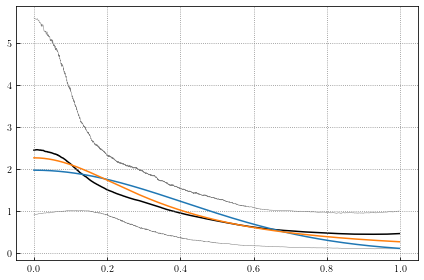

In [91]:
fig = plt.figure(figsize=(6,4))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

ax.plot(Xps,np.mean(p_Xp,axis=1),color='black',zorder=1)
ax.plot(Xps,np.quantile(p_Xp,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(Xps,np.quantile(p_Xp,0.95,axis=1),color='grey',lw=0.5,zorder=1)

ax.plot(Xps,truncatedNormal(Xps,*xp_gaussian_soln.x,0))
ax.plot(Xps,lorentzian(Xps,*xp_lorentzian_soln.x,0))

plt.tight_layout()
plt.show()

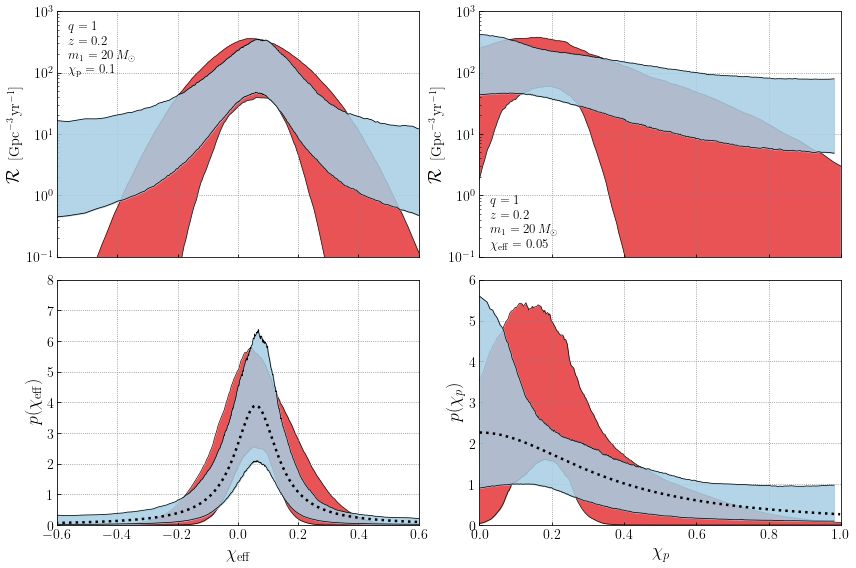

In [103]:
fig = plt.figure(figsize=(12,8))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(4)
    
ax.plot(Xeffs[::10],np.quantile(dR_dXeff[::10],0.05,axis=1),color='black',lw=0.775,zorder=3)
ax.plot(Xeffs[::10],np.quantile(dR_dXeff[::10],0.95,axis=1),color='black',lw=0.775,zorder=3)
ax.fill_between(Xeffs[::10],
                np.quantile(dR_dXeff[::10],0.05,axis=1),
                np.quantile(dR_dXeff[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

ax.plot(lvk_chiEff_grid,np.quantile(lvk_R_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_chiEff_grid,np.quantile(lvk_R_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_chiEff_grid,
                np.quantile(lvk_R_Xeff,0.05,axis=0),
                np.quantile(lvk_R_Xeff,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(1e-1,1e3)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.94,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.88,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.82,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.76,r'$\chi_\mathrm{p}=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(4)

ax.plot(Xps[::10],np.quantile(dR_dXp[::10],0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xps[::10],np.quantile(dR_dXp[::10],0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xps[::10],
                np.quantile(dR_dXp[::10],0.05,axis=1),
                np.quantile(dR_dXp[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

ax.plot(lvk_chiP_grid,np.quantile(lvk_R_Xp,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_chiP_grid,np.quantile(lvk_R_Xp,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_chiP_grid,
                np.quantile(lvk_R_Xp,0.05,axis=0),
                np.quantile(lvk_R_Xp,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-1,1e3)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

ax.text(0.03,0.23,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.17,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.11,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.05,r'$\chi_\mathrm{eff} = 0.05$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(4)

ax.plot(Xeffs[::10],np.quantile(p_Xeff[::10],0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xeffs[::10],np.quantile(p_Xeff[::10],0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xeffs[::10],
                np.quantile(p_Xeff[::10],0.05,axis=1),
                np.quantile(p_Xeff[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

ax.plot(lvk_chiEff_grid,np.quantile(lvk_p_Xeff,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_chiEff_grid,np.quantile(lvk_p_Xeff,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_chiEff_grid,
                np.quantile(lvk_p_Xeff,0.05,axis=0),
                np.quantile(lvk_p_Xeff,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

ax.plot(Xeffs,lorentzian(Xeffs,*xeff_lorentzian_soln.x,-1),color='black',ls=':',lw=2.5,)

ax.tick_params(labelsize=14)
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,8)

ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=18)
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(4)

ax.plot(Xps[::10],np.quantile(p_Xp[::10],0.05,axis=1),color='black',lw=0.75,zorder=3)
ax.plot(Xps[::10],np.quantile(p_Xp[::10],0.95,axis=1),color='black',lw=0.75,zorder=3)
ax.fill_between(Xps[::10],
                np.quantile(p_Xp[::10],0.05,axis=1),
                np.quantile(p_Xp[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=2)

ax.plot(lvk_chiP_grid,np.quantile(lvk_p_Xp,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.plot(lvk_chiP_grid,np.quantile(lvk_p_Xp,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=1)
ax.fill_between(lvk_chiP_grid,
                np.quantile(lvk_p_Xp,0.05,axis=0),
                np.quantile(lvk_p_Xp,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0)

ax.plot(Xps,lorentzian(Xps,*xp_lorentzian_soln.x,0),color='black',ls=':',lw=2.5,)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,6)

ax.set_xlabel('$\chi_p$',fontsize=18)
ax.set_ylabel(r'$p(\chi_p)$',fontsize=18)

plt.tight_layout()
plt.savefig('Xeff_Xp_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()